<a href="https://colab.research.google.com/github/zahrasa/Sentiment-Analysis-of-imdb-movie-reviews-/blob/main/XGBoost_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import metrics

download dataset

In [2]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Download the dataset
! rm -rf * 
! gdown 1M2BZan7tAbefEQXo3Yy5SUrGDpdedhcW

Downloading...
From: https://drive.google.com/uc?id=1M2BZan7tAbefEQXo3Yy5SUrGDpdedhcW
To: /content/imdb_movie_reviews.zip
100% 26.9M/26.9M [00:00<00:00, 46.5MB/s]


In [5]:
! unzip "imdb_movie_reviews.zip"
! rm -r "imdb_movie_reviews.zip"

Archive:  imdb_movie_reviews.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


import training and test data

In [6]:
imdb_data_train = pd.read_csv("Train.csv")
train_reviews = imdb_data_train.text[:]
train_sentiments = imdb_data_train.label[:]

imdb_data_test = pd.read_csv("Test.csv")
test_reviews = imdb_data_test.text[:]
test_sentiments = imdb_data_test.label[:]

#label count
print("number of texts and labels in train set:")
print(train_reviews.shape, train_sentiments.shape)
print("number of texts and labels in test set:")
print(test_reviews.shape, test_sentiments.shape)
print("\n")
print("number of 0s and 1s labels in train set:")
print(imdb_data_train['label'].value_counts())
print("number of 0s and 1s are somewhat equal. So data train set is balanced.\n\n")

number of texts and labels in train set:
(40000,) (40000,)
number of texts and labels in test set:
(5000,) (5000,)


number of 0s and 1s labels in train set:
0    20019
1    19981
Name: label, dtype: int64
number of 0s and 1s are somewhat equal. So data train set is balanced.




In [7]:
print("5 first train set:")
imdb_data_train.head()

5 first train set:


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
print("5 first test set:")
imdb_data_test.head()

5 first test set:


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


transformed label data

In [9]:
#labeling the sentient data
lb = LabelBinarizer()
#transformed sentiment data
sentiment_data_train = lb.fit_transform(imdb_data_train['label'])
sentiment_data_test = lb.fit_transform(imdb_data_test['label'])
print(sentiment_data_train.shape)
print(sentiment_data_test.shape)


#Spliting the sentiment data
train_sentiments = sentiment_data_train[:]
test_sentiments = sentiment_data_test[:]
print(train_sentiments)
print(test_sentiments)

(40000, 1)
(5000, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


starting preprocessing
Tokenization of text

In [10]:
tokenizer = ToktokTokenizer()
#Setting English stopwords
import nltk
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Removing the html strips

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(strip_html)
imdb_data_test['text'] = imdb_data_test['text'].apply(strip_html)

print(imdb_data_train.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0


Removing the square brackets

In [12]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_between_square_brackets)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_between_square_brackets)

print(imdb_data_train.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0


removing the stopwords

In [13]:
#set stopwords to english
stop = set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_stopwords)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_stopwords)

print(imdb_data_train.head(5))
print(imdb_data_test.head(5))

{'we', 'who', 'were', 'more', 'aren', 'be', "needn't", "you're", 'all', 'itself', 'is', 'needn', 'as', 'mustn', 'our', 'further', 'just', 'have', 'with', 'yours', 'why', 'or', 'was', 'off', 'shouldn', 'ain', 'very', 'o', 'does', 'because', 'if', 'of', 'to', "you'd", 'hers', 'd', 'some', 'he', 'above', 'when', 'y', "didn't", 'doesn', 'so', 'has', 'on', "isn't", 'those', 'most', 'these', "shan't", 'its', 'by', 'while', 'out', 'what', 'are', 'between', 'but', "should've", "you'll", 'm', 'weren', 'you', 'after', 'yourself', 'how', 'myself', 'didn', 'had', 'wasn', 'them', 'each', 'until', 'ma', 'below', 'which', 'wouldn', 'yourselves', 'she', 'ourselves', 'about', 'over', 's', 'such', 'should', "hadn't", "won't", 'don', 'then', "wouldn't", 'through', "wasn't", 'couldn', 'mightn', "hasn't", 'few', 'the', 'again', 've', "mustn't", 'been', 'this', 'now', 'not', 'own', 'hadn', "it's", 'did', 'nor', 'your', 'any', "don't", 'same', 'can', "aren't", 'themselves', 'that', 'a', 'into', 'there', "cou

Define function for removing special characters

In [14]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_special_characters)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_special_characters)

print(imdb_data_train.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  grew  b 1965  watching loving Thunderbirds mat...      0
1  put movie DVD player  sat coke chips  expectat...      0
2  people know particular time past like feel nee...      0
3  Even though great interest Biblical movies  bo...      0
4  Im die hard Dads Army fan nothing ever change ...      1
                                                text  label
0  always wrote series complete stinkfest Jim Bel...      0
1  1st watched 1272002  3 10 DirSteve Purcell   T...      0
2  movie poorly written directed fell asleep 30 m...      0
3  interesting thing Miryang  Secret Sunshine  ac...      1
4  first read  berlin meer   expect much thought ...      0


Stemming the text

In [15]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(simple_stemmer)
imdb_data_test['text'] = imdb_data_test['text'].apply(simple_stemmer)

print(imdb_data_train.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  grew b 1965 watch love thunderbird mate school...      0
1  put movi dvd player sat coke chip expect hope ...      0
2  peopl know particular time past like feel need...      0
3  even though great interest biblic movi bore de...      0
4  im die hard dad armi fan noth ever chang that ...      1
                                                text  label
0  alway wrote seri complet stinkfest jim belushi...      0
1  1st watch 1272002 3 10 dirstev purcel typic ma...      0
2  movi poorli written direct fell asleep 30 minu...      0
3  interest thing miryang secret sunshin actor je...      1
4  first read berlin meer expect much thought rig...      0


Remove Low Frequency Words of data sets

In [16]:
freq_train = pd.Series(' '.join(imdb_data_train['text']).split()).value_counts()
less_five_freq_train = freq_train[(freq_train <5)]
print(less_five_freq_train)

freq_test = pd.Series(' '.join(imdb_data_test['text']).split()).value_counts()
less_five_freq_test = freq_test[(freq_test <5)]
print(less_five_freq_test)

imdb_data_train['text'] = imdb_data_train['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
imdb_data_test['text'] = imdb_data_test['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_test))

startth           4
postlethwait      4
kopolski          4
crystallin        4
fizzi             4
                 ..
himselfconsequ    1
janether          1
saysth            1
exroomm           1
me810             1
Length: 105841, dtype: int64
dissuad      4
burnt        4
callou       4
castro       4
sleepless    4
            ..
halldavi     1
lilian       1
accenty      1
corbi        1
vilnach      1
Length: 28197, dtype: int64


normalizing

In [17]:
#normalized train reviews
norm_train_reviews = imdb_data_train.text[:]
print(norm_train_reviews.head(5))

#Normalized test reviews
norm_test_reviews = imdb_data_test.text[:]
print(norm_test_reviews.head(5))

0    grew b 1965 watch love thunderbird mate school...
1    put movi dvd player sat coke chip expect hope ...
2    peopl know particular time past like feel need...
3    even though great interest biblic movi bore de...
4    im die hard dad armi fan noth ever chang that ...
Name: text, dtype: object
0    alway wrote seri complet jim belushi involv he...
1    1st watch 3 10 typic mari kate amp ashley fare...
2    movi poorli written direct fell asleep 30 minu...
3    interest thing secret sunshin actor lee shina ...
4    first read berlin expect much thought right pe...
Name: text, dtype: object


TFIDF feature vector

In [18]:
# Count vectorizer for TFIDF
tv = TfidfVectorizer()

# transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

# transformed test reviews
tv_test_reviews = tv.transform(norm_test_reviews)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)

Tfidf_train: (40000, 27127)
Tfidf_test: (5000, 27127)


training AND predictng the bayes model with TFIDF

In [19]:
#training the nive bayes
clf = xgb.XGBClassifier(n_estimators = 10)

# fitting the bayes for bag of words
clf_tfidf = clf.fit(tv_train_reviews,train_sentiments.ravel())

# Predicting the model for bag of words
clf_tfidf_predict = clf.predict(tv_test_reviews)

ROC

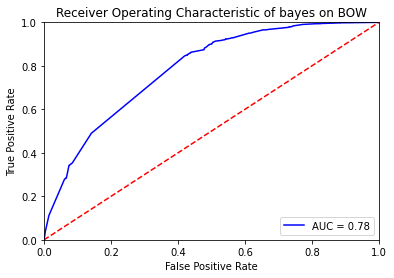

In [20]:
# ROC
probs_bow = clf.predict_proba(tv_test_reviews)
preds_bow = probs_bow[:,1]
fpr_bow , tpr_bow , threshold_bow = metrics.roc_curve(test_sentiments,preds_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)

plt.title('Receiver Operating Characteristic of bayes on BOW')
plt.plot(fpr_bow, tpr_bow, 'b', label='AUC = %0.2f' % roc_auc_bow)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy

In [21]:
# Accuracy score for tfidf features
clf_tfidf_score=accuracy_score(test_sentiments,clf_tfidf_predict)
print("mnb_tfidf_score :",clf_tfidf_score)

mnb_tfidf_score : 0.7112


Classification report

In [22]:
# Classification report for tfidf features
clf_tfidf_report = classification_report(test_sentiments,clf_tfidf_predict,target_names=['Positive','Negative'])
print(clf_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.80      0.56      0.66      2495
    Negative       0.66      0.86      0.75      2505

    accuracy                           0.71      5000
   macro avg       0.73      0.71      0.70      5000
weighted avg       0.73      0.71      0.70      5000



Compute Area Under the Curve (AUC):

In [23]:
fpr_tfidf, tpr_tfidf, thresholds_tfidf = metrics.roc_curve(test_sentiments,clf_tfidf_predict)
auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
print("AUC tfidf :", auc_tfidf)

AUC tfidf : 0.7109036436145745


confusion matrix

In [24]:
# confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments,clf_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[2152  353]
 [1091 1404]]


word cloud for positive review words

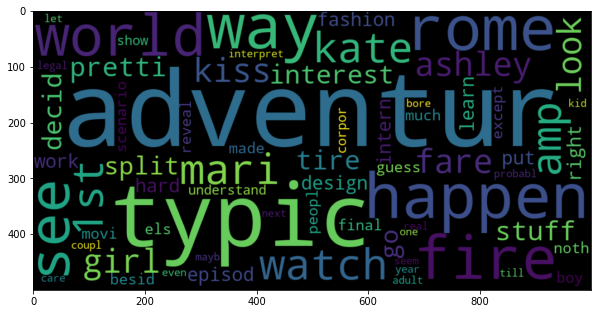

In [25]:
#test
plt.figure(figsize=(10,10))
positive_text=norm_test_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

word cloud for negative review words

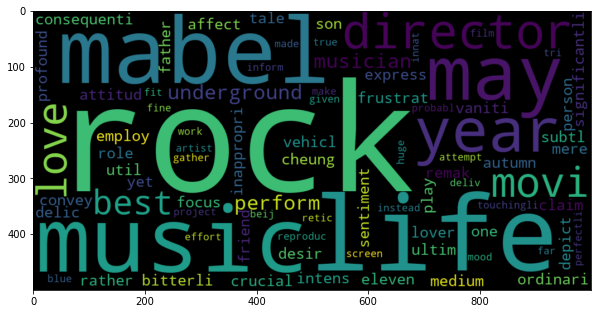

In [26]:
#test
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()